### Simulating an Ising Model with Glauber Dynamics


In [89]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Background
add formulas with latex and stuff

In [180]:
class GlauberDynamics:
    """
    A class for simulating the spin flips in an Ising Model

    Args:
        grid (array): Lattice of particles' spins, -1 = down | +1 = up
        temp (float, opt.): Temperature of the model. Default is 0
        seed (float, opt.): Random seed for simulation, Default is None
        store_history (bool, opt.): Keeps a record of past steps. Default is False.

    Attributes:
        history (list, opt.): Record of past grids

    Methods:
        step: Simulate a single step of the process
        run: Simulate the process for a given number of steps

    Notes:
        Algorithm used: https://en.wikipedia.org/wiki/Glauber_dynamics
    """
    def __init__(self, grid, temp= 0, seed= None, store_history= False):
        np.random.seed(seed)
        self.grid = grid
        self.temp = temp
        # boundary conditions, edges are given values of 0
        self.grid_copy = np.pad(grid, pad_width= 1)
        self.history = [self.grid_copy.copy()]
        self.store_history = store_history
        
        pass
    
    def step(self):
        """Chooses a random lattice site and determines if it flips."""
        i = np.random.randint(1, len(self.grid_copy) - 1)
        j = np.random.randint(1, len(self.grid_copy[0]) - 1)

        # Calculate the energy difference if the spin is flipped
        spin_sum = self.grid_copy[i+1][j] + self.grid_copy[i][j+1] + self.grid_copy[i-1][j] + self.grid_copy[i][j-1]
        del_E = 2 * self.grid_copy[i][j] * spin_sum

        # Compute the probability of flipping based on the temperature
        if self.temp != 0:
            p = 1 / (1 + np.exp(del_E / self.temp))
        else:
            p = 1 if del_E < 0 else 0  # Flip only if energy decreases

        # Flip the spin with probability p
        if np.random.rand() < p:
            self.grid_copy[i][j] *= -1

    @staticmethod
    def check_difference(grid1, grid2):
        """Check the total number of different sites between two grids"""
        return np.sum(grid1 != grid2)

    def run(self, n):
        """
        Simulates spin flips for n_steps.

        Args:
            n (int): The number of steps to simulate
        """    
        for i in range(n):
            self.step()
            #Store the self.grid_copy only if it is different from the last element in the history
            if self.store_history == True and not np.array_equal(self.history[-1],self.grid_copy):
                self.history.append(self.grid_copy.copy())

    def get_energy(self):
        """Computes the total energy of the lattice by summing all neighboring interactions"""
        energy = 0
        #TODO vectorize this, currently is O(n^2) if someone can speed this up
        for i in range(1, len(self.grid_copy) - 1):
            for j in range(1, len(self.grid_copy[0]) - 1):
                energy += self.grid_copy[i+1][j] + self.grid_copy[i][j+1] + self.grid_copy[i-1][j] + self.grid_copy[i][j-1]
        return energy


    def __str__(self):
        """
        Prints the current grid. Red = Up | Blue = Down | White = Boundary
        """
        plt.figure()
        plt.imshow(self.grid_copy, cmap='coolwarm')
        plt.title(f"Temperature:{self.temp}")
        return ""

Test

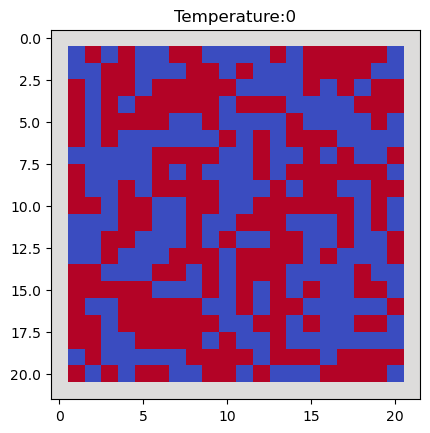

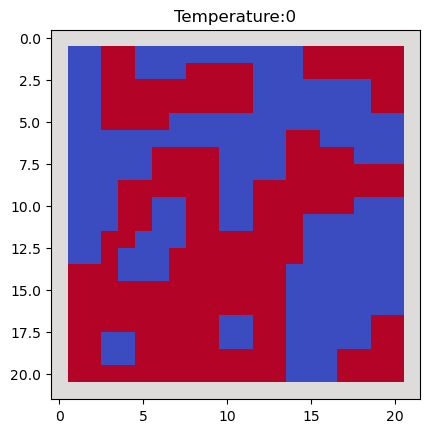

In [187]:
myGrid = np.random.choice((-1,1), size= (20,20))
# myGrid = np.array([-1,-1,-1,-1,-1,-1,1,1,1,1,1,1])[:,None]

model = GlauberDynamics(myGrid, temp= 0, store_history= False, seed= 0) # Critical temp = 2.27
print(model)
model.run(10000)
print(model)

Troubleshoot this to fix the model.history (I left this in case we would need it later)

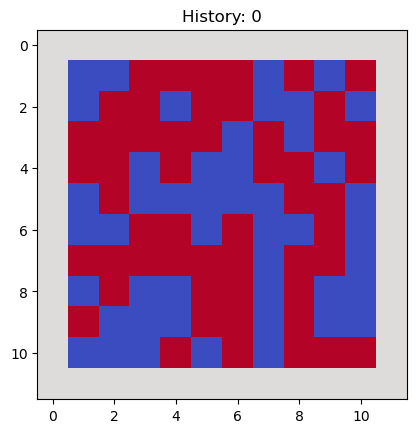

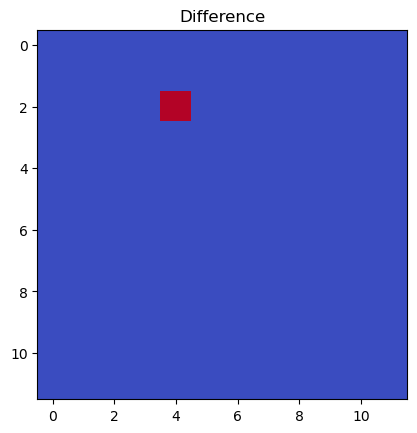

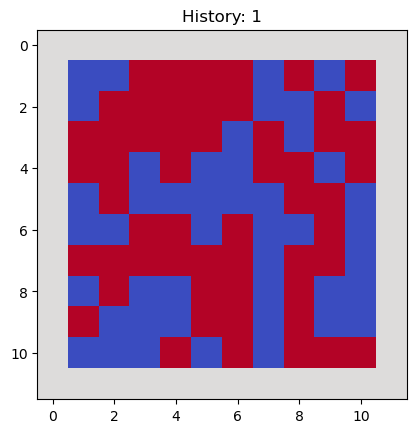

In [185]:
#Used this to troubleshoot the model.history and be able to fix it in order to see the animation

#Set Grid parameters and simulate
myGrid = np.random.choice((-1,1), size= (10,10))
model=GlauberDynamics(myGrid, temp= 0, store_history= True, seed= 0)
model.run(10)

#Display initial conditions
graph1=model.history[0]
plt.figure()
plt.title('History: 0')
plt.imshow(graph1, cmap='coolwarm')
plt.show()

#Use a for loop to display every change between differences in history
for i in range (len(model.history)-1):
    #Assign the last two states to graph1 and graph2
    graph1=model.history[i]
    graph2=model.history[i+1]

    #Check if last two states are equal
    if not np.array_equal(graph1,graph2):
        # It should always be in this output of the if statement
        # Because if not it would mean that we are storing a matrix
        # That has no change

        #Calculate the difference between the last two states and display it
        Temp=graph2-graph1
        plt.figure()
        plt.title('Difference')
        plt.imshow(Temp, cmap='coolwarm')
        plt.show()

        #Display the new state
        plt.figure()
        plt.title(f"History: {i+1}")
        plt.imshow(graph2,cmap='coolwarm')
        plt.show()
    else:
        # If there is no change between these two states say so
        # If there is no change there is a problem in storing in history matrix
        print('No difference')

## Animation

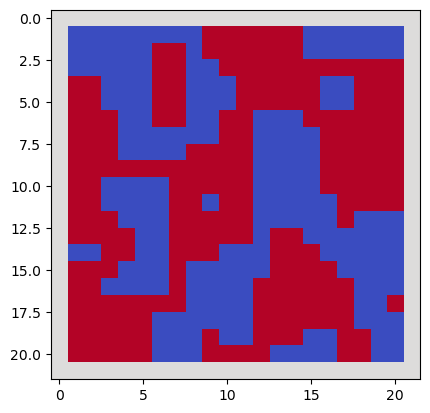

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters for the grid
myGrid = np.random.choice((-1,1), size= (20,20))  # Grid creation
n_steps = 1000         # Number of frames in the animation

#Assign the model using the GlauberDynamics class
model=GlauberDynamics(myGrid, temp= 0, store_history= True, seed= 0)

# Run simulation n times
model.run(n_steps)


# Set up the figure and initial plot
fig, ax = plt.subplots()
im = ax.imshow(model.history[0], cmap='coolwarm', vmin=-1, vmax=1)

# Initialization function: displays the first frame
def init():
    im.set_data(model.history[0])
    return [im]

# Update function: updates the image data for each frame
def update(frame):
    im.set_data(model.history[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=len(model.history), init_func=init, blit=True, interval=50)

HTML(ani.to_jshtml())

